In [19]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd

In [23]:
data = np.load('npz/BTCUSD/BTCUSD2023-05-01.npz', allow_pickle=True)['data']
df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'vol'])
df

,timestamp,open,high,low,close,vol
0,2023-05-01 00:00:00,29237.5,29239.5,29237.0,29239.0,59395.0
1,2023-05-01 00:00:05,29239.0,29250.0,29239.0,29249.5,144575.0
2,2023-05-01 00:00:10,29250.0,29259.0,29248.0,29257.0,285878.0
3,2023-05-01 00:00:15,29257.5,29259.0,29253.0,29254.0,108818.0
4,2023-05-01 00:00:20,29259.0,29259.0,29254.0,29259.0,42836.0
...,...,...,...,...,...,...
17274,2023-05-01 23:59:30,28080.5,28081.0,28080.5,28081.0,50002.0
17275,2023-05-01 23:59:35,28080.5,28081.0,28080.5,28081.0,382.0
17276,2023-05-01 23:59:40,28080.5,28081.0,28073.5,28074.0,161262.0
17277,2023-05-01 23:59:45,28074.0,28074.0,28062.0,28062.5,864790.0


In [28]:
data = np.load('npz/BTCUSD_D.npz', allow_pickle=True)['data']
df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'vol'])
# Преобразование 'timestamp' в datetime и установка его как индекс DataFrame
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df

,open,high,low,close,vol
timestamp,,,,,
2023-05-01,29237.5,29339.0,27659.5,28068.0,921697021.0
2023-05-02,28068.0,28889.0,27869.0,28665.0,677060949
2023-05-03,28665.5,29275.5,28105.5,29036.0,870134810
2023-05-04,29036.0,29380.0,28660.0,28831.0,517973476
2023-05-05,28831.5,29700.0,28720.0,29519.5,806295485
...,...,...,...,...,...
2024-05-22,70184.0,70702.0,68908.0,69188.0,566044978.0
2024-05-23,69188.5,70129.0,66115.0,67991.5,908764552.0
2024-05-24,67991.0,69277.0,66631.5,68581.0,417688388.0


<Axes: xlabel='timestamp'>

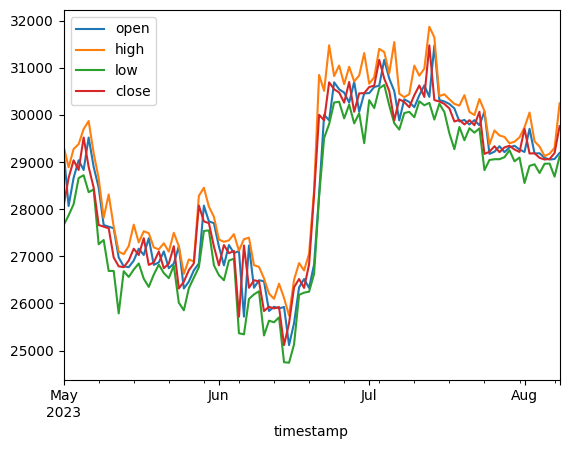

In [29]:
df[['open', 'high', 'low', 'close']][:100].plot()